## Looking at some feature relationships 

#### Performing initial exploratory data analysis to understand the relationships in the data better and form opinions for the more advanced data analytics

#### Tags:
    Data: labeled data, manually created data
    Technologies: python, pandas
    Techniques: exploratory data analysis
    
#### Resources:
    

In [63]:
import pandas as pd
%matplotlib inline

In [64]:
# Read the data into pandas df
# We start with the data that was prepared thorugh the project Checking the data by inspecting feature values

df = pd.read_csv('../data/data_efr.csv', delimiter=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19191 entries, 0 to 19190
Data columns (total 8 columns):
index             19191 non-null int64
ride_departure    19191 non-null object
capacity          19191 non-null float64
tickets_7_usd     19191 non-null float64
tickets_10_usd    19191 non-null float64
tickets_16_usd    19191 non-null float64
tickets_20_usd    19191 non-null float64
direction         19191 non-null object
dtypes: float64(5), int64(1), object(2)
memory usage: 1.2+ MB


# DATA DESCRIPTION:

#### The manually created data is used here. It shows the bus rides between 2 US cities named A and B. The column descriptions are 

### Description of the columns:

* index: unique identifier for the bus ride
* ride_departure: departure date and time of the ride
* capacity: number of total seats available in the bus
* tickets_{X}_usd: number of tickets sold for X USD
* direction: direction of the bus ride, either A->B or B->A


#### Here i will add some additional columns that can be engineered from the given data

* date - the date of the event
* hour - the hour of the event
* dayofweek - the day in the week

In [68]:
# Adding additional date related columns

df.ride_departure = pd.to_datetime(df.ride_departure)
df['date'] = [dt.date() for dt in df.ride_departure]
df.date = pd.to_datetime(df.date)

df['hour'] = [dt.hour for dt in df.ride_departure]
df['dayofweek'] = [dt.weekday() for dt in df.date]
df['year'] = [dt.year for dt in df.date]

# Now we set the ride departure as index as we can then use pandas to create interesting overviews
df.index = df.ride_departure
df.drop(['ride_departure'],axis=1,inplace = True)
df = df.sort_index()

df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19191 entries, 2015-01-01 08:15:00 to 2017-04-30 23:35:00
Data columns (total 11 columns):
index             19191 non-null int64
capacity          19191 non-null float64
tickets_7_usd     19191 non-null float64
tickets_10_usd    19191 non-null float64
tickets_16_usd    19191 non-null float64
tickets_20_usd    19191 non-null float64
direction         19191 non-null object
date              19191 non-null datetime64[ns]
hour              19191 non-null int64
dayofweek         19191 non-null int64
year              19191 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(4), object(1)
memory usage: 1.8+ MB


#### Defining the goal of EDA

Using the data set we want to be able to say how many tickets from each of the group will be sold in the next x period. Hence, i like to align the EDA with the goal of the whole initiative and just to take a look at the data from different perspectives and start to have ideas where to start first.

EDA is a great step before starting feature engineering as it gives ideas on how to aggregate the data differently to expose the key features that will achieve the goal.

The data has a temporal component, that is, it develops over time, hence we can start with the general overview of ticket sales over the perios the data was recorded as this will be key to understand the frequency at which to create the features that catch this temporal aspect.


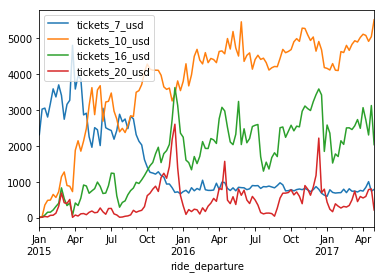

In [70]:
# Weekly total sales of tickets development over the years

dt = df[['tickets_7_usd','tickets_10_usd','tickets_16_usd','tickets_20_usd']].resample('W').sum()
dt.plot(legend=True, label="Number of tickets sold")


Above we see the development of weekly ticket sales over the period of 2 years. There are some interesting developments here, like number of tickets at 7 usd has decreased over the years and is now at a constant weekly rate, while the
the number of tickets sold at 10 usd has increased a lot from Jan 2015 to Jul 2015 at the expense of 7 usd tickets, and is still growing in the recent times but likely because the sale of 20 usd tickets is falling down in recent period
The sale of 16 usd tickets has increased sharply in period Jul 15 to Jan 2016 and has since had a very slight increase.

Interesting bit of information is that the yearly seasonality can be seem to spike over the holiday season as people are ready to buy higher value tickets then. It might be a good idea to think how to model holidays or holiday season in a separate or special way.


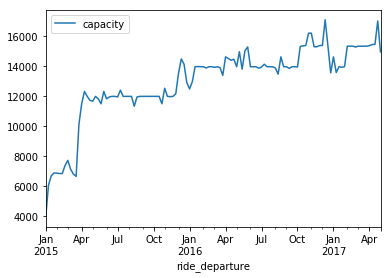

In [51]:
# Weekly capacity development over the years

dt = df[['capacity']].resample('W').sum()
dt.plot(legend=True, label="Capacity development")


The weekly total capacity has been increasing steadily. The seasonality can be seen, but is less obvoius here.

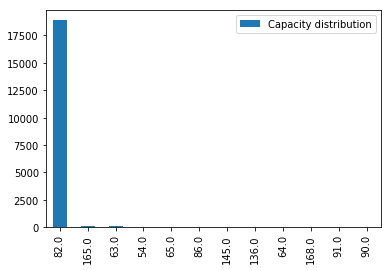

In [42]:
df['capacity'].value_counts().plot(kind='bar',legend=True, label="Capacity distribution")


Looking at the above capacity distribution over the whole period gives us the insight that the predominant capacity of a ride is 82, while the others are much less common.

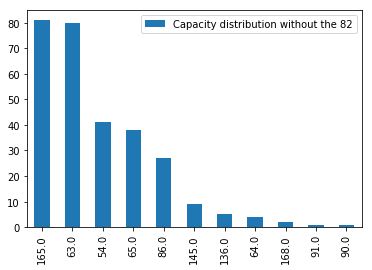

In [52]:
dfo = df[df['capacity']!=82.0]
dfo['capacity'].value_counts().plot(kind='bar',legend=True, label="Capacity distribution without the 82")


If we exclude the capacity 82, then we can better see the relationship of other capacities.

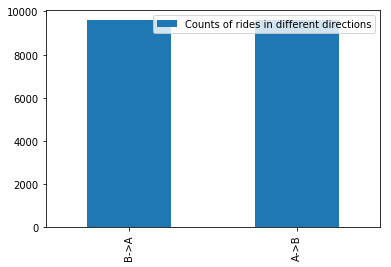

In [72]:
df['direction'].value_counts().plot(kind='bar',legend=True, label="Counts of rides in different directions")


In [101]:
direction = df.drop(['capacity','index','hour','year','tickets_7_usd','tickets_10_usd','tickets_16_usd','tickets_20_usd'],axis=1)
direction = direction.groupby(['dayofweek','direction']).count()        
direction.reset_index(level=1, inplace=True)

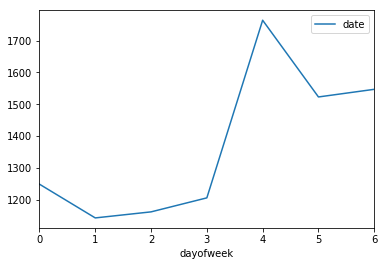

In [103]:
direction[direction['direction']=='A->B'].plot()

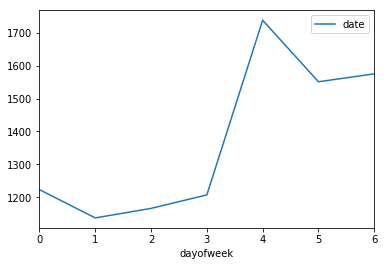

In [104]:
direction[direction['direction']=='B->A'].plot()

Looking at directions, it looks like there are the same number of rides in both directions. At this point there seems to be no value in this information, hence this column might be a good one the remove form the future model. Or wee need to think how to create a feature that can use this information in a way that makes a differentiation between these 2 variables.

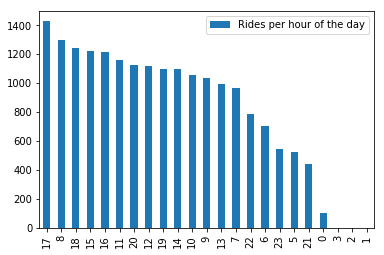

In [54]:
df.hour.value_counts().plot(kind='bar',legend=True, label= 'Rides per hour of the day')

Looking at when the most of the rides have happened we can see that the peak is from 8-9 and 17-18h. This might be connected to the 9-17h regular working hours peaks. It seems there are almost no rides in period from 0-4h.

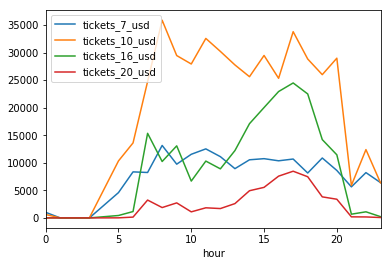

In [99]:
hour = df.drop(['capacity','direction','date','index','dayofweek','year'],axis=1)
hour = hour.groupby(['hour']).sum()        
hour.plot()


We can see similar development if we take a look at the sale of the tickets, the peak of more expensive tickets is from 16-18h.

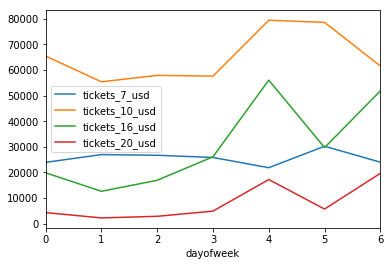

In [74]:
dayofweek = df.drop(['capacity','direction','date','index','hour','year'],axis=1)
dayofweek = dayofweek.groupby(['dayofweek']).sum()        
dayofweek.plot()


The above line chart of different tickets shows a peak in sales of the more expensive ticket at day 4 (Friday) and similar spike at day 6 (Sunday). This suggests that the line might be a weekend line, where most of the increase in travel is over the weekend.

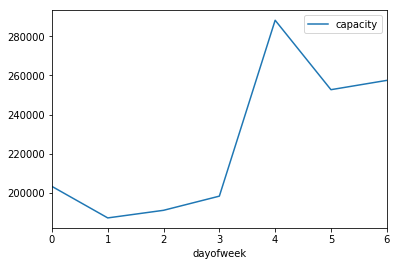

In [75]:
dayofweek = df.drop(['direction','date','index','hour','year','tickets_7_usd','tickets_10_usd','tickets_16_usd','tickets_20_usd'],axis=1)
dayofweek = dayofweek.groupby(['dayofweek']).sum()        
dayofweek.plot()


The capacity is significantly increased as weekend in support of the previous assumption.

#### Summary

To summarize the findings:

    1. there is increase in tickets sales over the years, hence trend is positive
    2. usual capacity of the buses is 82 places per ride
    3. capacity is steadily increasing over the years
    4. most of the passengers travel in the 16-18h period
    5. there are peaks in travel on friday and sunday
    6. there is pronounced seasonality during Christmas period (best sales period)
    
These facts can help us prepare for the feature engineering better.